# Best entries and exits for daily trading of EVMOS 

EVMOS is one of the tokens on Cosmos ecosystem that had generous staking awards since its inception. Staking rewards are awarded at the end of the epoch, which happens to be at the same time every day, at around 9pm CET. Many stakers collect their rewards and immediately sell them causing a drop in price that during bull market tends to recover by the end of the following epoch. 

I attempted to find the time of the day with the highest and the lowest prices in order to find the best entries and exits for the trades with the following project. 

In [50]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

The prices have orginally been acquired through an API but as it is a moving data I replaced it here with csv file. I would download hourly prices for the past 10 days. 

In [51]:
price=pd.read_csv('evmos_price_real.csv', usecols=['datetime','EVMOS'], parse_dates=['datetime'])
price = price.set_index('datetime')
price['date']=price.index.date
price['time']=price.index.time
price.tail(5)

,EVMOS,date,time
datetime,,,
2023-05-23 18:00:00,0.153763,2023-05-23,18:00:00
2023-05-23 19:00:00,0.154081,2023-05-23,19:00:00
2023-05-23 20:00:00,0.157089,2023-05-23,20:00:00
2023-05-23 21:00:00,0.160802,2023-05-23,21:00:00
2023-05-23 22:00:00,0.171977,2023-05-23,22:00:00



I calculated a daily mean of the prices for each of the days. This will allow me to create a column with the value of the deviation from the mean.

In [53]:
daily_mean = price.EVMOS.groupby(price['date']).mean()
daily_mean.columns=['date','mean']
daily_mean

date
2023-05-13    0.200509
2023-05-14    0.198788
2023-05-15    0.203434
2023-05-16    0.201498
2023-05-17    0.189505
2023-05-18    0.184357
2023-05-19    0.175964
2023-05-20    0.169849
2023-05-21    0.158136
2023-05-22    0.145481
2023-05-23    0.147122
Name: EVMOS, dtype: float64

I create a new dataframe that contains the prices, daily means and deviation from the mean.

In [80]:
evmos_dev= pd.merge(left=price, right=daily_mean, left_on='date', right_on='date', how='left',suffixes=('_price','_mean'))
evmos_dev['dev_from_mean']=evmos_dev['EVMOS_price']-evmos_dev['EVMOS_mean']
evmos_dev.reset_index().set_index(['date','time'])
evmos_dev.tail(5)

,EVMOS_price,date,time,EVMOS_mean,dev_from_mean
236,0.153763,2023-05-23,18:00:00,0.147122,0.006641
237,0.154081,2023-05-23,19:00:00,0.147122,0.006959
238,0.157089,2023-05-23,20:00:00,0.147122,0.009967
239,0.160802,2023-05-23,21:00:00,0.147122,0.013680
240,0.171977,2023-05-23,22:00:00,0.147122,0.024855


We can visualise the divergence from the mean at each hour using a heatmap. The blues show where the prices are highest and yellow when lowest.

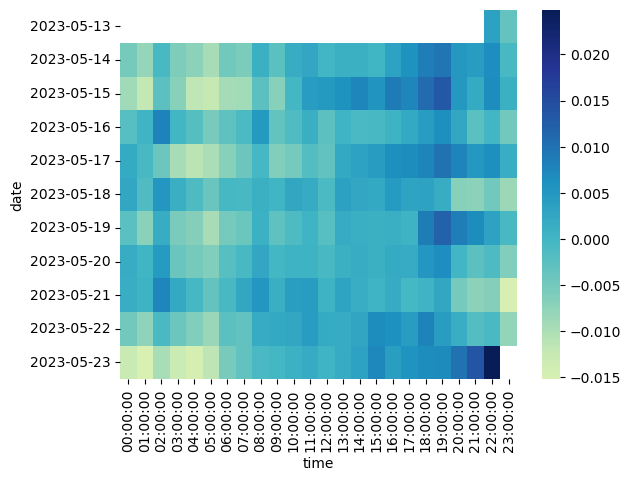

In [57]:
evmos_dev_pp = pd.pivot_table(evmos_dev, values='dev_from_mean', index=['date'],
                    columns=['time'])
sns.heatmap(data=evmos_dev_pp,center=0,cmap="YlGnBu")
plt.show()

We can observe the average prices changes for each hour in the past 10 days on a graph below.

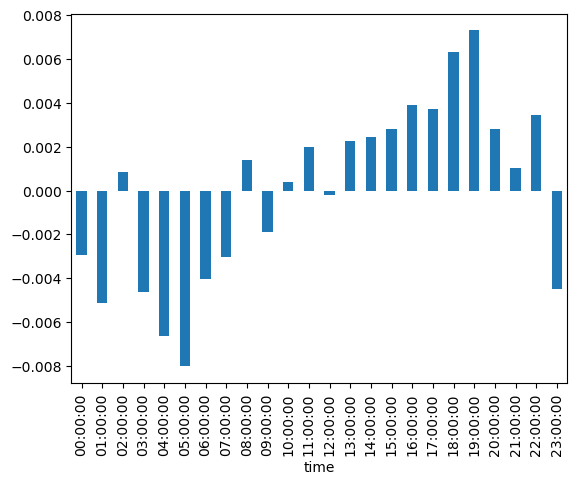

In [72]:
#Calculating average deviations from the mean every hour in the past 10 days.
time_dev = evmos_dev.groupby('time').dev_from_mean.mean()
time_dev.plot(kind='bar')
plt.show()

In [74]:
max_hour = time_dev.idxmax().hour
min_hour = time_dev.idxmin().hour
print(f'The prices are lowest on average at {min_hour}:00 and highest at {max_hour}:00.')

The prices are lowest on average at 5:00 and highest at 19:00.


It seems that the best time to buy is on average at 5am and to sell at 7pm. We can backtest this strategy buy calculating the returns for each of the days in our data.

In [76]:
buysell= price[(price.index.hour == min_hour )| (price.index.hour== max_hour)].copy()
# Create a dictionary that maps integers to strings
mapping = {min_hour:'buy', max_hour:'sell'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
buysell['signal'] = buysell.index.hour.map(mapping)
buysell['return (%)']= (buysell.EVMOS.pct_change()* 100).round(2)
buysell.dropna()
buysell.sort_values(by='date')

,EVMOS,date,time,signal,return (%)
datetime,,,,,
2023-05-14 05:00:00,0.189376,2023-05-14,05:00:00,buy,NaN
2023-05-14 19:00:00,0.208241,2023-05-14,19:00:00,sell,9.96
2023-05-15 05:00:00,0.191121,2023-05-15,05:00:00,buy,-8.22
2023-05-15 19:00:00,0.216665,2023-05-15,19:00:00,sell,13.37
2023-05-16 05:00:00,0.196141,2023-05-16,05:00:00,buy,-9.47
2023-05-16 19:00:00,0.207857,2023-05-16,19:00:00,sell,5.97
2023-05-17 05:00:00,0.179542,2023-05-17,05:00:00,buy,-13.62
2023-05-17 19:00:00,0.199620,2023-05-17,19:00:00,sell,11.18
2023-05-18 19:00:00,0.185994,2023-05-18,19:00:00,sell,3.02


In [77]:
sell = buysell[buysell['signal']=='sell']
avg_return = sell["return (%)"].mean().round(2)

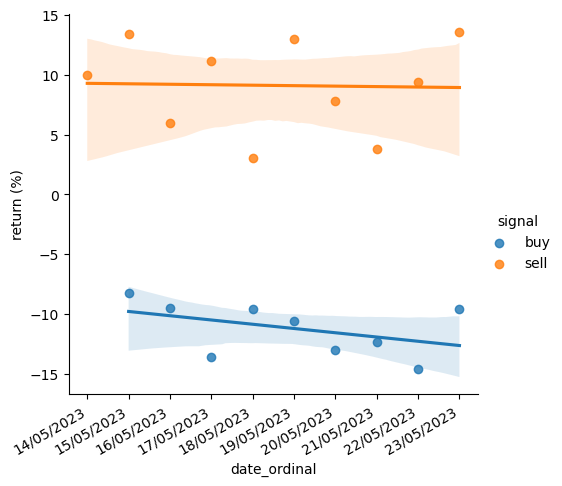

In [78]:

buysell['date'] = pd.to_datetime(buysell['date'])
buysell['date_ordinal'] = buysell['date'].apply(lambda date: mdates.date2num(date.to_pydatetime()))

sns.lmplot(data=buysell, y= 'return (%)', x='date_ordinal', hue='signal')

# Format x axis to display dates instead of numbers
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()


In [82]:
print(f"You can make on average {avg_return}% a day by buying EVMOS at {min_hour}:00 and selling at {max_hour}:00 every day!")

You can make on average 9.1% a day by buying EVMOS at 5:00 and selling at 19:00 every day!
